# Angle Recovery with GDM and Isomap

## Content

1. [Data Preparation](Read-Data)
2. [Geodesic Distance Matrix (GDM)](#Geodesic-Distance-Matrix)
3. [Isomap Embeddings](#Isomap)

## Read Data

Data used:
- Protein: 5a1a (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5a1a.pdb1-500.jpg)

In [1]:
import os
import h5py
import numpy as np
from time import time

import sys
sys.path.append("../../..") 
from cryoem.plots import plot_angles_count, plot_euclidean_space, save_space_plot
from IPython.display import Image

In [2]:
PROTEIN="5a1a"
ROOT_DIR = "../../.."
NUM_PROJECTIONS = 5000

In [3]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


### True Angles

In [4]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

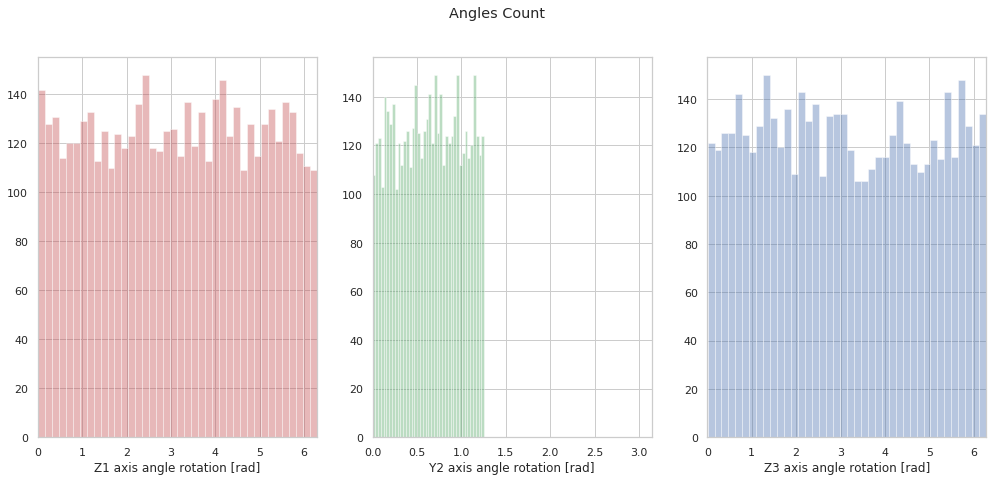

In [5]:
plot_angles_count(angles_true)

### Predicted Angles

In [6]:
angle_shift = [0.0, 0.0, 0.0]
angle_coverage = [2.0, 0.4, 2.0]

In [7]:
# from tensorflow.python.framework import ops

# def mod_angles(e, angle_shift, angle_coverage):
#     values = ops.convert_to_tensor(e.values if isinstance(e, ops.IndexedSlices) else e, name="e")

#     v1 = tf.math.mod(values[0], 2*np.pi)
#     v2 = tf.math.mod(values[1], np.pi)
#     v3 = tf.math.mod(values[2], 2*np.pi)
    
#     v1 = tf.clip_by_value(v1, angle_shift[0]*np.pi, angle_shift[0]*np.pi+angle_coverage[0]*np.pi)
#     v2 = tf.clip_by_value(v2, angle_shift[1]*np.pi, angle_shift[1]*np.pi+angle_coverage[1]*np.pi)
#     v3 = tf.clip_by_value(v3, angle_shift[2]*np.pi, angle_shift[2]*np.pi+angle_coverage[2]*np.pi)


#     return tf.stack((v1, v2, v3), axis=-1)

In [8]:
low_ang = [x*np.pi for x in angle_shift]
high_ang = [x*np.pi for x in angle_coverage]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(angles_true), 3))

# angles_predicted = [tf.Variable(e, constraint=lambda x: mod_angles(x, angle_shift, angle_coverage)) for e in euler]
angles_predicted = [tf.Variable(e) for e in euler]


angles_predicted = np.array(angles_predicted)
angles_predicted.shape

(5000,)

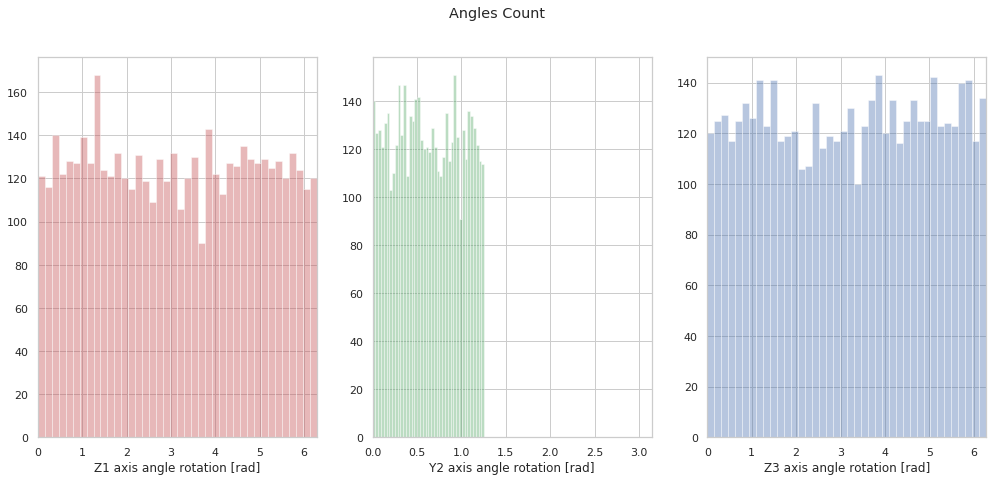

In [9]:
plot_angles_count(angles_predicted)

In [10]:
plot_euclidean_space(angles_predicted)

In [11]:
plot_euclidean_space(angles_true)

---

## Geodesic Distance Matrix

This is done using the kNN with geodesic distances between true angles. Later, when we start to use the real projections instead of true angles, we will be using the `projections` as input to kNN and the distance metric will be the one learned from the SiameseNN (`d_P`).

In [148]:
from cryoem.projections import RotationMatrix
from cryoem.quaternions import euler2quaternion, d_q, quaternion2euler

In [149]:
angles = np.reshape(data["Angles"], (data["Angles"].shape[0], -1))
angles.shape

(5000, 3)

In [114]:
plot_euclidean_space(angles)

In [115]:
quaternions = euler2quaternion(angles).numpy()
quaternions.shape

(5000, 4)

In [116]:
quaternions

array([[ 4.03648413e-01,  8.20132166e-02, -7.51684727e-01,
        -5.15084325e-01],
       [ 6.46273862e-02,  2.51017529e-01,  2.89089071e-01,
         9.21542734e-01],
       [-8.40526850e-02, -2.66363927e-02, -2.74991566e-04,
        -9.96105202e-01],
       ...,
       [ 8.97044907e-02,  5.06111847e-01, -5.63994616e-01,
         6.46307957e-01],
       [ 1.64750795e-01,  2.73562466e-01,  9.37946611e-01,
        -1.35192110e-01],
       [-3.46783831e-02,  4.00947271e-01,  5.77596189e-01,
        -7.10226259e-01]])

In [123]:
ipv.figure(width=500, height=400)
pos_q0 = np.where(quaternions[:,3] >= 0)[0]
neg_q0 = np.where(quaternions[:,3] < 0)[0]
ipv.scatter(quaternions[pos_q0, 0], quaternions[pos_q0, 1], quaternions[pos_q0, 2], marker="sphere", color="blue", size=1)
ipv.scatter(quaternions[neg_q0, 0], quaternions[neg_q0, 1], quaternions[neg_q0, 2], marker="sphere", color="pink", size=1)

ipv.xlim(-1, 1)
ipv.ylim(-1, 1)
ipv.zlim(-1, 1)
ipv.show()

In [15]:
# def d_p(a, b):
#     return d_q(a, b)

def d_p(a, b):
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    if np.dot(a, b) > 1 or np.dot(a,b) < -1:
        return 0.0
    return np.mean(np.arccos(2*np.power(np.dot(a, b), 2)-1))#np.mean(2*np.arccos(np.abs(np.dot(a, b))))

In [17]:
d_p(quaternions[0], quaternions[1])

1.7387541033898515

In [18]:
start_time = time()

A = np.zeros((len(quaternions), len(quaternions)))

for i in range(len(quaternions)):
    for j in range(i, len(quaternions)):
        A[i, j] = A[j, i] = d_p(quaternions[i], quaternions[j])
        
print(f"--- {time() - start_time} seconds ---")

--- 336.8841235637665 seconds ---


In [ ]:
# np.save(A, "data/quaternion_A.npy")

## Isomap

In [20]:
from sklearn.manifold import Isomap
from matplotlib import pyplot as plt
import ipyvolume as ipv

In [21]:
start_time = time()

embedding = Isomap(n_neighbors=120, n_components=4)
A_transformed = embedding.fit_transform(A)

print(f"--- {time() - start_time} seconds ---")

--- 115.73724484443665 seconds ---


In [151]:
def logQall(qs):
    def logQ(q):
        if q[3]<0:
            q =-q
        theta = np.arccos(q[3])
        n = np.array([q[0], q[1], q[2]])
        norm = n / np.linalg.norm(n)
        return norm * theta
    logs = np.zeros((qs.shape[0], qs.shape[1]-1))
    for i, q in enumerate(qs):
        logs[i] = logQ(q)
    return logs

In [152]:
logs = logQall(quaternions)

In [155]:
ipv.figure(width=500, height=400)
ipv.scatter(logs[:, 0], logs[:, 1], logs[:, 2], marker="sphere", color="blue", size=1)
# ipv.xlim(-80, 80)
# ipv.ylim(-80, 80)
# ipv.zlim(-80, 80)
ipv.show()

In [150]:
ipv.figure(width=500, height=400)
ipv.scatter(A_transformed[:, 0], A_transformed[:, 1], A_transformed[:, 2], marker="sphere", color="blue", size=1)
ipv.xlim(-80, 80)
ipv.ylim(-80, 80)
ipv.zlim(-80, 80)
ipv.show()

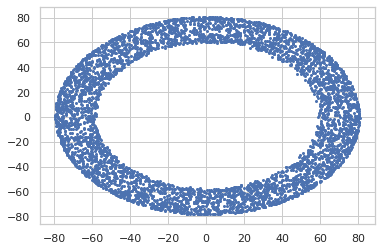

In [140]:
plt.plot(A_transformed[:,0], A_transformed[:,1], lw=0, marker="o", markersize=2)

In [134]:
ipv.figure(width=500, height=400)
ipv.scatter(quaternions[:, 0], quaternions[:, 1], quaternions[:, 2], marker="sphere", color="blue", size=1)
# ipv.xlim(-1, 1)
# ipv.ylim(-1, 1)
# ipv.zlim(-1, 1)
ipv.show()

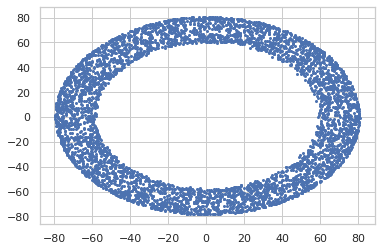

In [135]:
plt.plot(A_transformed[:,0], A_transformed[:,1], lw=0, marker="o", markersize=2)

In [92]:
ipv.figure(width=500, height=400)
ipv.scatter(quaternions[:, 0], quaternions[:, 1], quaternions[:, 2], marker="sphere", color="blue", size=1)
# ipv.xlim(-1, 1)
# ipv.ylim(-1, 1)
# ipv.zlim(-1, 1)
ipv.show()

In [96]:
from scipy.spatial.transform import Rotation as R

In [97]:
r = R.from_quat(A_transformed, normalized=False)

In [98]:
angles_predicted = r.as_euler('zyz', degrees=False)
angles_predicted.shape

(5000, 3)

In [99]:
angles

array([[2.74129289, 0.84906729, 5.48198312],
       [0.05198987, 0.52439503, 0.5559678 ],
       [5.01955447, 0.17657386, 1.26418297],
       ...,
       [5.3902725 , 1.07968313, 5.74111375],
       [1.17188032, 0.65006988, 2.25601305],
       [2.54509695, 0.82837041, 2.37254411]])

In [100]:
angles_predicted

array([[-2.62453116,  2.56996272,  1.0607892 ],
       [-1.74351199,  2.64195661, -1.63473982],
       [ 2.04985773,  2.57070681, -2.90225341],
       ...,
       [ 2.59280713,  2.58481977,  0.49195832],
       [ 3.11645782,  2.5352882 , -2.43099979],
       [ 2.87770807,  2.55441461,  0.66185342]])

In [101]:
# plot_euclidean_space(angles_predicted)

In [102]:
plot_euclidean_space(angles_predicted)

In [105]:
rm = RotationMatrix(angles_predicted)[:,:3]

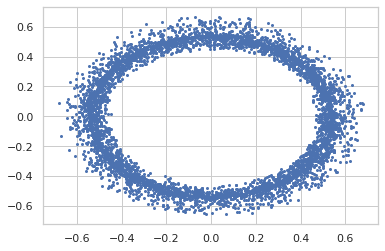

In [107]:
plt.plot(rm[:,0], rm[:,1], lw=0, marker="o", markersize=2)

#### Scale Embedding

In [17]:
radius = np.max(A_transformed)

In [18]:
A_transformed_norm = A_transformed/radius
translate_z_axis = -1 - np.min(A_transformed_norm[:,2])

In [19]:
A_transformed_norm[:,2] = A_transformed_norm[:,2]+translate_z_axis

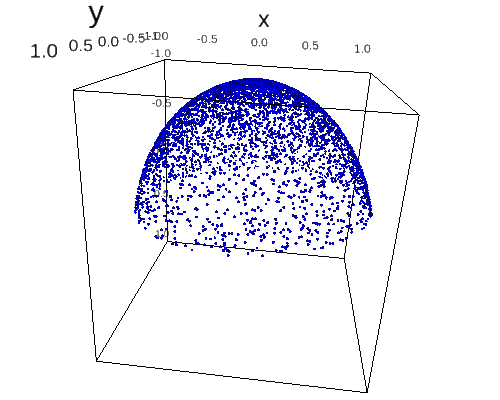

In [20]:
ipv.figure(width=500, height=400)
ipv.scatter(A_transformed_norm[:, 0], A_transformed_norm[:, 1], A_transformed_norm[:, 2], marker="sphere", color="blue", size=1)
ipv.xlim(-1, 1)
ipv.ylim(-1, 1)
ipv.zlim(-1, 1)
ipv.show()

In [21]:
filename = f"figures/{PROTEIN}_Isomap_random_all"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

In [22]:
angles_true_rotated = RotationMatrix(angles_true)[:,:3]

##### Flip

In [23]:
for i, f in enumerate(A_transformed_norm):
    A_transformed_norm[i] = [f[0], -f[1], -f[2]]

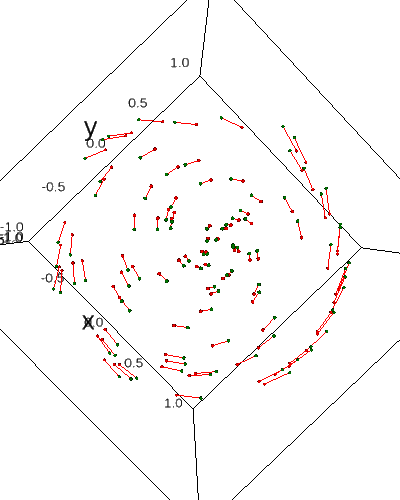

In [24]:
ipv.clear()
selected = range(100)
aps = np.take(A_transformed_norm, selected, axis=0)
ats = np.take(angles_true_rotated, selected, axis=0)
ipv.scatter(ats[:,0], ats[:,1], ats[:,2], marker="sphere", color="green", size=1)
ipv.scatter(aps[:,0], aps[:,1], aps[:,2], marker="sphere", color="red", size=1)
for i in selected:
    connection0 = [ats[i,0], aps[i,0]]
    connection1 = [ats[i,1], aps[i,1]]
    connection2 = [ats[i,2], aps[i,2]]
    ipv.plot(connection0, connection1, connection2,color="red", lynestyle="--")
ipv.xlim(-1, 1);ipv.ylim(-1,1);ipv.zlim(-1, 1)
ipv.show()

In [25]:
filename = f"figures/{PROTEIN}_Isomap_random"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

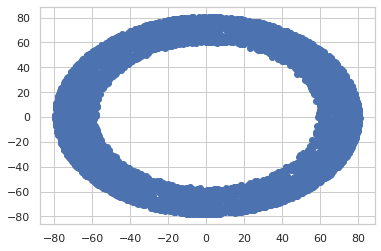

In [45]:
plt.plot(A_transformed[:,0], A_transformed[:,1], lw=0, marker="o")

In [ ]:
def rotationMat2angles(rot_mat):
    beta = np.arccos(a[2])
    gamma = np.arcsin(a[1]/np.sin(beta))
    # TODO: missing the 3rd angle!!!!

---